In [3]:
import pandas as pd
import os
import glob
import torch
from datasets import Dataset
import sentencepiece
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AdamW, PegasusForConditionalGeneration, PegasusTokenizer
import sacrebleu
import evaluate
import bert_score
from transformers import T5ForConditionalGeneration, T5Tokenizer, get_linear_schedule_with_warmup
from nltk.translate.bleu_score import sentence_bleu

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Define filler words
FILLER_WORDS = {
    "umm", "uh", "like", "you know", "I mean", "well", "so",  
    "hmm", "er", "ah", "oh", "okay", "ok", "right", "actually",  
    "basically", "literally", "kind of", "sort of", "just", "you see",  
    "I guess", "I suppose", "I think", "I feel like", "you know what I mean",  
    "alright", "you know what I'm saying", "I dunno", "to be honest", "TBH",  
    "at the end of the day", "let me think", "let me see", "I mean like"
}

In [8]:
# Function to clean text (removes filler words)
def clean_text(text):
    if pd.isna(text):
        return ""
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in FILLER_WORDS]
    return " ".join(cleaned_words)


In [14]:
def preprocess_data(folder_path, output_file):
    csv_files = sorted(glob.glob(os.path.join(folder_path, "*.csv")))

    with open(output_file, "w", encoding="utf-8") as f_out:
        for file_path in csv_files:
            df = pd.read_csv(file_path)

            try:
                primary_topic = df[df["Utterance"] == "primary_topic"]["Sub topic"].values[0]
                secondary_topic = df[df["Utterance"] == "secondary_topic"]["Sub topic"].values[0]
                summary = df[df["Utterance"] == "summary"]["Sub topic"].values[0]
            except IndexError:
                primary_topic = "Unknown"
                secondary_topic = "Unknown"
                summary = "No summary available"

            # Remove rows that contain "Primary Topic", "Secondary Topic", and "Summary"
            df = df[~df["Utterance"].isin(["primary_topic", "secondary_topic", "summary"])]

            # Convert Emotion to numeric
            df["Emotion"] = pd.to_numeric(df["Emotion"], errors="coerce").fillna(0).astype(int)

            # Compute Global Emotion
            global_emotion = df["Emotion"].mean()

            # Write header
            f_out.write(f"<PrimaryTopic: {primary_topic}> <SecondaryTopic: {secondary_topic}> <GlobalEmotion: {global_emotion:.2f}>\n")

            for _, row in df.iterrows():
                speaker = "Therapist" if row["Type"] == "T" else "Patient"
                dialogue_function = row.get("Dialogue_Act", "unknown")  # Handle missing column
                sub_topic = row["Sub topic"] if pd.notna(row["Sub topic"]) else "general"
                emotion = int(row["Emotion"])
                utterance = clean_text(row["Utterance"])

                f_out.write(f"{speaker} [DialogueFunction={dialogue_function}] (Sub_topic={sub_topic}) (Emotion={emotion}): {utterance}\n")

            f_out.write(f"Summary: {summary}\n\n")
            # Add separator
            f_out.write("\n" + "="*80 + "\n\n")

    print(f" Preprocessed data saved to {output_file}")

In [15]:
# Define paths for train, val, and test
datasets = {
    "Train": "train_dialogues.txt",
    "Validation": "val_dialogues.txt",
    "Test": "test_dialogues.txt"
}

for folder, output in datasets.items():
    preprocess_data(folder, output)

 Preprocessed data saved to train_dialogues.txt
 Preprocessed data saved to val_dialogues.txt
 Preprocessed data saved to test_dialogues.txt


In [17]:
#Using pegasus-large
model_name = "google/pegasus-large"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

In [18]:
def read_txt_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.read()

    samples = data.split("=" * 80)  # Splitting conversations
    dialogues, reference_summaries = [], []

    for sample in samples:
        lines = sample.strip().split("\n")
        dialogue, summary = [], None

        for line in lines:
            if line.startswith("Summary:"):
                summary = line.replace("Summary:", "").strip()
                break 
            dialogue.append(line)

        if dialogue and summary:
            dialogues.append(" ".join(dialogue))
            reference_summaries.append(summary)
    return dialogues, reference_summaries

In [19]:
# Load training and validation data
train_dialogues, train_summaries = read_txt_file("train_dialogues.txt")
val_dialogues, val_summaries = read_txt_file("val_dialogues.txt")
test_dialogues, test_summaries = read_txt_file("test_dialogues.txt")

train_dataset = Dataset.from_dict({"input": train_dialogues, "output": train_summaries})
val_dataset = Dataset.from_dict({"input": val_dialogues, "output": val_summaries})

In [20]:
train_df = pd.DataFrame(train_dataset)
val_df = pd.DataFrame(val_dataset)

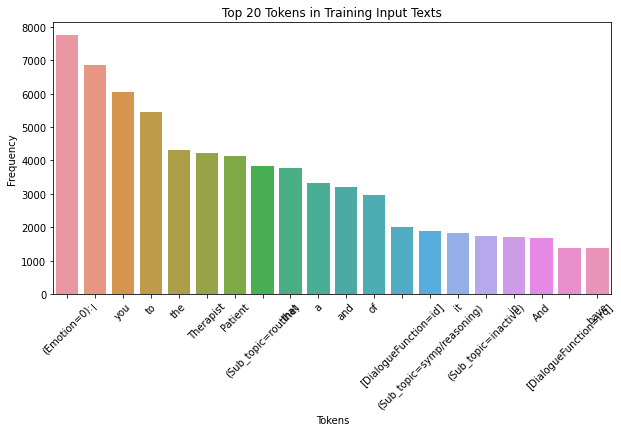

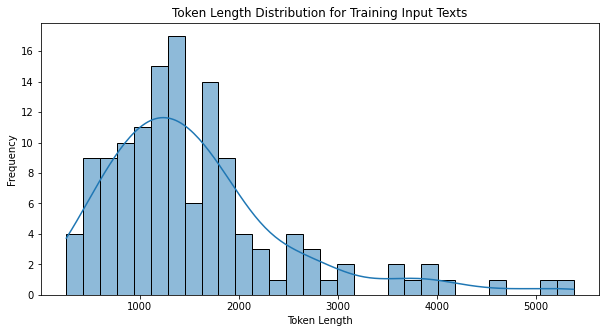

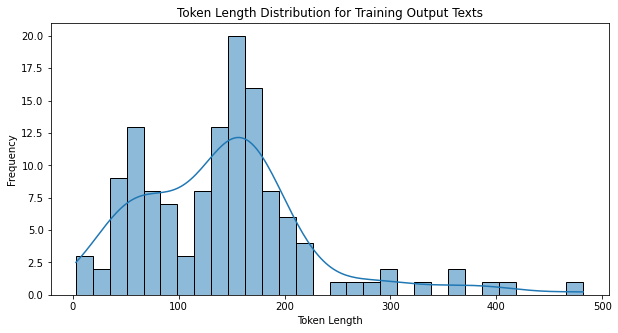

In [23]:
# visualising frequency of Tokens in the Training Input
def plot_token_frequency(texts, title, num_tokens=20):
    all_tokens = " ".join(texts).split()
    token_counts = Counter(all_tokens)
    common_tokens = token_counts.most_common(num_tokens)
    tokens, counts = zip(*common_tokens)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(tokens), y=list(counts))
    plt.title(title)
    plt.xlabel("Tokens")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()
    
plot_token_frequency(train_df['input'], "Top 20 Tokens in Training Input Texts")

def plot_token_length_distribution(texts, title):
    token_lengths = [len(text.split()) for text in texts]
    plt.figure(figsize=(10, 5))
    sns.histplot(token_lengths, bins=30, kde=True)
    plt.title(title)
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.show()

plot_token_length_distribution(train_df['input'], "Token Length Distribution for Training Input Texts")
plot_token_length_distribution(train_df['output'], "Token Length Distribution for Training Output Texts")


In [24]:
def display_random_samples(df, num_samples=5):
    samples = df.sample(num_samples)
    for i, (input_text, output_text) in enumerate(zip(samples['input'], samples['output'])):
        print(f"Sample {i+1}:")
        print(f"Input: {input_text}")
        print(f"Output: {output_text}\n")

display_random_samples(train_df)

Sample 1:
Input: <PrimaryTopic: Behaviour> <SecondaryTopic: alcohol-fighting> <GlobalEmotion: 0.00> Therapist [DialogueFunction=gt] (Sub_topic=inactive) (Emotion=0): Hi, Alex. My name is Tony. I'll be your nurse for today. How are you doing? Patient [DialogueFunction=gt] (Sub_topic=symp/reasoning) (Emotion=0): I'm okay, I guess waiting for the stitches to come out and be nice. Therapist [DialogueFunction=irq] (Sub_topic=symp/reasoning) (Emotion=0): Oh, what happened? Oh, God. Can you tell me a little bit more about this firefight? Patient [DialogueFunction=id] (Sub_topic=story) (Emotion=0): kit storytime you're ready for this. brown my girls having a fantastic time looking off on fleek and fish. And then this girl, she has the nerve to stare at me from across the room. It gives me kind of kind of this. And then she comes up to me, she bumps into me spills my drink. And she comes up and then she's like, a man. I'm like, excuse me. obviously I pushed her she pushed me kind of thing. And 

In [25]:
# Tokenizing the dataset for Pegasus 
def preprocess_function(examples):
    model_inputs = tokenizer(examples["input"], truncation=True, padding="max_length", max_length=512)
    labels = tokenizer(examples["output"], truncation=True, padding="max_length", max_length=128)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x7f434a137550> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [26]:
#Summary Dataset
class TextSummaryDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        labels = torch.tensor(example["labels"], dtype=torch.long)
        labels[labels == tokenizer.pad_token_id] = -100  # Ignore padding in loss
        return {
            "input_ids": torch.tensor(example["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(example["attention_mask"], dtype=torch.long),
            "labels": labels
        }

In [40]:
model.to(device)
train_dataset_pt = TextSummaryDataset(train_dataset)
val_dataset_pt = TextSummaryDataset(val_dataset)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset_pt, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_pt, batch_size=BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

EPOCHS = 10
train_losses, val_losses = [], []

# Early stopping parameters
best_val_loss = float("inf") 
patience = 3 
early_stopping_counter = 0

for epoch in range(EPOCHS):
    # Training phase
    print(f"\n Epoch {epoch+1}/{EPOCHS}:")

    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device).long()

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device).long()

            outputs = model(**inputs, labels=labels)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f" Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        print(" Best validation loss improved! Saving model...")
        model.save_pretrained("pegasus-best")
        tokenizer.save_pretrained("pegasus-best")
    else:
        early_stopping_counter += 1
        print(f" Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(" Early stopping triggered. Training stopped!")
            break
    scheduler.step()
    
model.save_pretrained("pegasus-final")
tokenizer.save_pretrained("pegasus-final")


 Epoch 1/10:
Training Loss: 3.3512
 Validation Loss: 3.1534
 Best validation loss improved! Saving model...

 Epoch 2/10:
Training Loss: 3.1956
 Validation Loss: 3.0809
 Best validation loss improved! Saving model...

 Epoch 3/10:
Training Loss: 3.0850
 Validation Loss: 3.0542
 Best validation loss improved! Saving model...

 Epoch 4/10:
Training Loss: 3.0639
 Validation Loss: 3.0317
 Best validation loss improved! Saving model...

 Epoch 5/10:
Training Loss: 2.9384
 Validation Loss: 3.0143
 Best validation loss improved! Saving model...

 Epoch 6/10:
Training Loss: 2.9354
 Validation Loss: 3.0099
 Best validation loss improved! Saving model...

 Epoch 7/10:
Training Loss: 2.8884
 Validation Loss: 2.9955
 Best validation loss improved! Saving model...

 Epoch 8/10:
Training Loss: 2.8368
 Validation Loss: 2.9905
 Best validation loss improved! Saving model...

 Epoch 9/10:
Training Loss: 2.8163
 Validation Loss: 2.9849
 Best validation loss improved! Saving model...

 Epoch 10/10:
Trai

('pegasus-final/tokenizer_config.json',
 'pegasus-final/special_tokens_map.json',
 'pegasus-final/spiece.model',
 'pegasus-final/added_tokens.json')

In [41]:
def plot_loss_curve(train_losses, val_losses, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Training & Validation Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

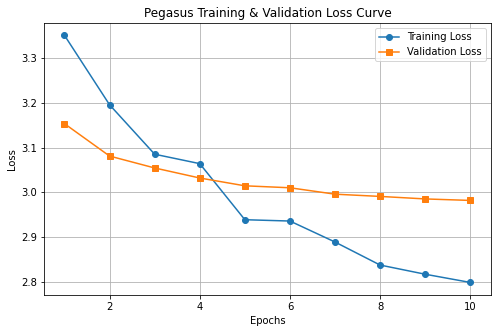

In [42]:
plot_loss_curve(train_losses, val_losses, "Pegasus")

In [45]:
# Load the saved model and tokenizer
model_name = "pegasus-final"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)
model.to(device)

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(1024, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05,

In [46]:
# Generate summary 
def generate_summary(dialogue_text):
    inputs = tokenizer(dialogue_text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  
    summary_ids = model.generate(**inputs, max_length=128, num_beams=5, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


generated_summaries = [generate_summary(dialogue) for dialogue in test_dialogues] 

for i, summary in enumerate(generated_summaries[:5]):
    print(f"Dialogue {i+1}: {test_dialogues[i]}")
    print(f"Generated Summary {i+1}: {summary}\n")

Dialogue 1: <PrimaryTopic: anxiety> <SecondaryTopic: hygiene-dog> <GlobalEmotion: 0.00> Therapist [DialogueFunction=id] (Sub_topic=story) (Emotion=0): Okay, a great job on your homework was really excellent. He listened to the imaginal exposure recording about six times. And you did the exposure, the in vivo exposure of walking around and touching things doorknobs and other surfaces and objects you normally wouldn't touch both at your house and other places you went, and you sat down on the floor, and you even ate lunch off the floor at your house and at your mom's house. Okay, and no washing, no wash, no, no hand washing, no extra washing. Perfect. Good for you. Okay, what did you learn from all that? Do you think over the course of the time you've done that? Patient [DialogueFunction=id] (Sub_topic=routine) (Emotion=0): It got easier. At the beginning. It was really hard. And I feel my stats were much higher than the end. I guess that was what we talked about the Therapist [DialogueF

In [47]:
# Calculate bleu score 
bleu = sacrebleu.corpus_bleu(generated_summaries, [test_summaries])
print(f" BLEU Score: {bleu.score:.2f}")


 BLEU Score: 4.21


In [ ]:
# Calculate rouge score
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=generated_summaries, references=test_summaries)

print(f" ROUGE-1 (R-1): {rouge_scores['rouge1']:.4f}")
print(f" ROUGE-2 (R-2): {rouge_scores['rouge2']:.4f}")
print(f" ROUGE-L (R-L): {rouge_scores['rougeL']:.4f}")

In [49]:
# Calculate BERTScore
P, R, F1 = bert_score.score(generated_summaries, test_summaries, model_type="microsoft/deberta-xlarge-mnli", lang="en")
print(f" BERTScore (F1): {F1.mean().item():.4f}")


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['classifier.bias', 'pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 BERTScore (F1): 0.4964


In [10]:
# Calculate BLEURT Score
bleurt = evaluate.load("bleurt")
bleurt_scores = bleurt.compute(predictions=generated_summaries, references=test_summaries)
avg_bleurt_score = sum(bleurt_scores['scores']) / len(bleurt_scores['scores'])
print(f" Average BLEURT Score: {avg_bleurt_score:.4f}")

INFO:tensorflow:Reading checkpoint C:\Users\dhawal bansal\.cache\huggingface\metrics\bleurt\default\downloads\extracted\5de534b8918e113a0ca034661916cfb79c6f226569dbc5f9f1502ecdaa8f3c35\bleurt-base-128.


INFO:tensorflow:Reading checkpoint C:\Users\dhawal bansal\.cache\huggingface\metrics\bleurt\default\downloads\extracted\5de534b8918e113a0ca034661916cfb79c6f226569dbc5f9f1502ecdaa8f3c35\bleurt-base-128.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


🔹 Average BLEURT Score: -0.6896


In [50]:
model_name = "t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [51]:
# Preprocessing for T5 model
def preprocess_T5(examples):
    inputs = ["summarize: " + doc for doc in examples["input"]]
    model_inputs = tokenizer(inputs, truncation=True, padding="max_length", max_length=512)
    labels = tokenizer(examples["output"], truncation=True, padding="max_length", max_length=128)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(preprocess_T5, batched=True)  
val_dataset = val_dataset.map(preprocess_T5, batched=True)     


 Epoch 1/10:
Training Loss: 4.8903
 Validation Loss: 3.5943
 Best validation loss improved! Saving model...

 Epoch 2/10:
Training Loss: 3.2351
 Validation Loss: 2.9836
 Best validation loss improved! Saving model...

 Epoch 3/10:
Training Loss: 2.9245
 Validation Loss: 2.9099
 Best validation loss improved! Saving model...

 Epoch 4/10:
Training Loss: 2.7790
 Validation Loss: 2.8885
 Best validation loss improved! Saving model...

 Epoch 5/10:
Training Loss: 2.6795
 Validation Loss: 2.8816
 Best validation loss improved! Saving model...

 Epoch 6/10:
Training Loss: 2.5757
 Validation Loss: 2.8818
 Early stopping counter: 1/3

 Epoch 7/10:
Training Loss: 2.5067
 Validation Loss: 2.8965
 Early stopping counter: 2/3

 Epoch 8/10:
Training Loss: 2.4590
 Validation Loss: 2.9022
 Early stopping counter: 3/3
 Early stopping triggered. Training stopped!


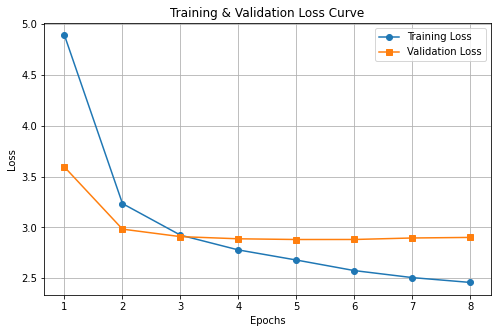

In [52]:
model.to(device)
train_dataset_pt = TextSummaryDataset(train_dataset)
val_dataset_pt = TextSummaryDataset(val_dataset)

BATCH_SIZE = 4 
train_loader = DataLoader(train_dataset_pt, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_pt, batch_size=BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=3e-5)  
EPOCHS = 10  
num_training_steps = EPOCHS * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0.1 * num_training_steps,  
    num_training_steps=num_training_steps
)

train_losses, val_losses = [], []
best_val_loss = float("inf")
patience = 3  # 
early_stopping_counter = 0

for epoch in range(EPOCHS):
    print(f"\n Epoch {epoch+1}/{EPOCHS}:")
    
    # Training Phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device).long()

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device).long()

            outputs = model(**inputs, labels=labels)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f" Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        print(" Best validation loss improved! Saving model...")
        model.save_pretrained("t5-large-best")
        tokenizer.save_pretrained("t5-large-best")
    else:
        early_stopping_counter += 1
        print(f" Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(" Early stopping triggered. Training stopped!")
            break

model.save_pretrained("t5-large-final")
tokenizer.save_pretrained("t5-large-final")

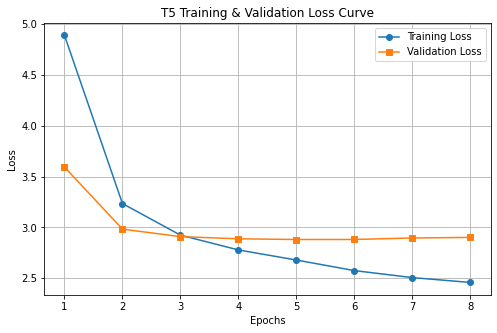

In [53]:
plot_loss_curve(train_losses, val_losses, "T5")

In [ ]:
model_name = "t5-large-final"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.to(device)

In [56]:
def generate_summary_T5(input_text):
    input_ids = tokenizer("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

generated_summaries = [generate_summary_T5(text) for text in test_dialogues] 
reference_summaries = test_summaries  

In [57]:
# Compute BLEU Score
bleu = sacrebleu.corpus_bleu(generated_summaries, [test_summaries])
print(f"🔹 BLEU Score: {bleu.score:.2f}")


🔹 BLEU Score: 5.61


In [ ]:
# Compute ROUGE scores
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print(f" ROUGE-1 (R-1): {rouge_scores['rouge1']:.4f}")
print(f" ROUGE-2 (R-2): {rouge_scores['rouge2']:.4f}")
print(f" ROUGE-L (R-L): {rouge_scores['rougeL']:.4f}")

In [4]:
# Compute BLEURT Score
bleurt = evaluate.load("bleurt")
bleurt_scores = bleurt.compute(predictions=generated_summaries, references=test_summaries)
avg_bleurt_score = sum(bleurt_scores['scores']) / len(bleurt_scores['scores'])
print(f" Average BLEURT Score: {avg_bleurt_score:.4f}")

INFO:tensorflow:Reading checkpoint C:\Users\dhawal bansal\.cache\huggingface\metrics\bleurt\default\downloads\extracted\5de534b8918e113a0ca034661916cfb79c6f226569dbc5f9f1502ecdaa8f3c35\bleurt-base-128.


INFO:tensorflow:Reading checkpoint C:\Users\dhawal bansal\.cache\huggingface\metrics\bleurt\default\downloads\extracted\5de534b8918e113a0ca034661916cfb79c6f226569dbc5f9f1502ecdaa8f3c35\bleurt-base-128.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


🔹 Average BLEURT Score: -0.5381


In [59]:
for i, summary in enumerate(generated_summaries[:5]):
    print(f"Dialogue {i+1}: {test_dialogues[i]}")
    print(f"Generated Summary {i+1}: {summary}\n")

Dialogue 1: <PrimaryTopic: anxiety> <SecondaryTopic: hygiene-dog> <GlobalEmotion: 0.00> Therapist [DialogueFunction=id] (Sub_topic=story) (Emotion=0): Okay, a great job on your homework was really excellent. He listened to the imaginal exposure recording about six times. And you did the exposure, the in vivo exposure of walking around and touching things doorknobs and other surfaces and objects you normally wouldn't touch both at your house and other places you went, and you sat down on the floor, and you even ate lunch off the floor at your house and at your mom's house. Okay, and no washing, no wash, no, no hand washing, no extra washing. Perfect. Good for you. Okay, what did you learn from all that? Do you think over the course of the time you've done that? Patient [DialogueFunction=id] (Sub_topic=routine) (Emotion=0): It got easier. At the beginning. It was really hard. And I feel my stats were much higher than the end. I guess that was what we talked about the Therapist [DialogueF

In [60]:
# Compute BERTScore
P, R, F1 = bert_score.score(generated_summaries, test_summaries, model_type="microsoft/deberta-xlarge-mnli",lang="en")
print(f" BERTScore (F1): {F1.mean().item():.4f}")


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['classifier.bias', 'pooler.dense.weight', 'classifier.weight', 'pooler.dense.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 BERTScore (F1): 0.5632
